<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#ComplementNB" data-toc-modified-id="ComplementNB-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ComplementNB</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Распознавание токсичных комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности.

Наша задача — обучить модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузим и подготовим данные.
2. Обучим разные модели. 
3. Сделаем выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm
import spacy


## Подготовка

In [2]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'C:/Users/ASUS/Desktop/PRACTICUM/Мои проекты/Toxic_comments/toxic_comments.csv'

if os.path.exists(pth1):
    file = pd.read_csv(pth1)
elif os.path.exists(pth2):
    file = pd.read_csv(pth2)
else:
    print('Ничего не получается...')

In [3]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
file.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [5]:
file.sample(10)

,Unnamed: 0,text,toxic
29910,29950,"""\n\n me be nice \n The Random Acts of Kindne...",0
109555,109652,"""\n\n ( \n\nI disagree with your definition of...",0
146980,147136,"Try using the dlw template, or re-sourcing. Fa...",0
39684,39734,"""\n\nI strongly recommend that you revert all ...",0
54076,54137,would mislead most reasonable people,0
85599,85680,"Nevermind, I tracked it down off of your contr...",0
113259,113357,Merge Proposal - January 2014==\n==,0
150127,150283,I'm Kissing up \n\nI want to kiss you ass,1
145799,145955,"""BELOW this comment>\nHello\nHello, Noel. Thou...",0
127597,127729,", 31 October 2011 (UTC) | decline=One unblock ...",0


в нашем распоряжении датасет из 159292 строк и 3 столбцов, важными для нас являются целевой признак 'toxic' и входной признак 'text'. Будем работать с англоязычными текстами, учтем это при выборе библиотеки для обнаружения стоп-слов и лемматизации. Отметим, что тексты содержат большое количество символов, используются разные регистры.


В качестве индексов назначим столбец заказчика Unnamed:0.

In [6]:
file.columns

Index(['Unnamed: 0', 'text', 'toxic'], dtype='object')

In [7]:
file.nunique()

Unnamed: 0    159292
text          159292
toxic              2
dtype: int64

In [8]:
file = file.set_index('Unnamed: 0').copy()

In [9]:
file.columns

Index(['text', 'toxic'], dtype='object')

In [10]:
file.duplicated().sum()

0

Дубликатов нет.

Определим пропорцию объектов разного класса для целевого признака.

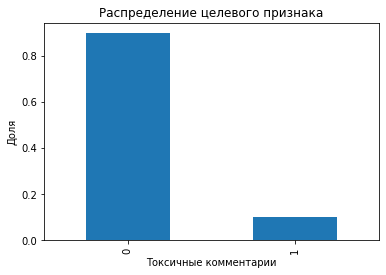

In [11]:
file.toxic.value_counts(normalize=True).plot(kind='bar') 
plt.title('Распределение целевого признака')
plt.xlabel('Токсичные комментарии')
plt.ylabel('Доля')
plt.show()

Приятно видеть, что токсичные комментарии составляют всего 10% от общего количества комментариев, атмосфера на площадке умеренно-дружелюбная, но будем учитывать сильный дисбаланс классов при обучении модели.

Создадим список текстов с использованием SpaCy для лемматизации.

In [12]:
nlp = spacy.load('en_core_web_sm')

def lemmatize_spacy(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

Для тестирования функции создадим небольшой образец.

In [13]:
sample = file.sample(15)

In [14]:
tqdm.pandas()
sample['lemm_spacy'] = sample['text'].progress_apply(lemmatize_spacy)

100%|██████████| 15/15 [00:00<00:00, 80.29it/s]


In [15]:
pd.set_option('display.max_colwidth', None)
sample

,text,toxic,lemm_spacy
Unnamed: 0,,,
19172,"""\nWe use whichever name, phrase, or descriptor best conveys the topic. Which, in this case, is to mention the wildly minority and specialised viewpoint that they are one lake briefly in Great Lakes, and that's it. We certainly don't edit-war to remove Lake Michigan and Lake Huron from lake lists. When 9001 people say X, and three people say Y, Y clearly doesn't """"best convey the topic"""". - One ping only """,0,use whichever phrase descriptor good convey topic case mention wildly minority specialised viewpoint lake briefly great lake certainly edit war remove lake michigan lake huron lake list people x people y y clearly good convey topic ping
118101,F**K YOUR GUTS \n\nlol ),1,gut lol
17437,Please don't tell me what to do. The discussion page indicates you are in a minority on this subject. Take your views there rather than getting rid of the links on your own. 198.204.92.193,0,tell discussion page indicate minority subject view getting rid link
154885,"""\n\nFact: The majority of soldiers serving in the Rhodesian Army at the time of the bush war were black.\nFact: The ZIPRA/ZANLA """"forces"""" never overcame the Rhodesian forces, the majority of internal engagements were short, sharp firefights, the usual result being either the complete annihilation, or dispersal of the terrorist groups involved. The external engagements, or camp attacks always resulted in overwhelming victories for the Rhodesian forces.\nFact: ZIPRA/ZANLA were both left wing organisations, with full backing from far-left Marxists states. \nFact: ZIPRA/ZANLA """"forces"""" deployed within Rhodesia preferred to not engage the Rhodesian armed forces, and this was also not their role, as operating in small groups of up to 20 men, without any form of air support, they could not take on the security on anything approaching equal terms. They were deployed primarily to """"politicise"""" the rural black population (usually by terrorising those who did not fully support of their parent organisation into doing so), and to destabilise the economy as much as possible by attacking soft targets. \nFact: Neither ZIPRA or ZANLA overcame (as you put it) the Rhodesian army. Possibly the conventionally trained ZIPRA troops who were held back in Zambia, and never committed to the bush war, could have defeated the Rhodesian forces in open battle, considering that towards the end of the war these conventionally trained troops were far better equipped than the Rhodesian forces, but as Nkomo never gave the go order, we will never know.\nBy the sounds of things though, you would not be happy to see anything that is not politically correct, no matter how factual""",0,fact majority soldier serve rhodesian army time bush war black fact zipra zanla force overcome rhodesian force majority internal engagement short sharp firefight usual result complete annihilation dispersal terrorist group involve external engagement camp attack result overwhelming victory rhodesian force fact zipra zanla leave wing organisation backing far leave marxist state fact zipra zanla force deploy rhodesia prefer engage rhodesian armed force role operate small group man form air support security approach equal term deploy primarily politicise rural black population usually terrorise fully support parent organisation destabilise economy possible attack soft target fact zipra zanla overcame rhodesian army possibly conventionally train zipra troop hold zambia commit bush war defeat rhodesian force open battle consider end war conventionally train troop far well equip rhodesian force nkomo give order know sound thing happy politically correct matter factual
107259,TUSC token ff3c4c432fe5ac19c4c17baebde12a00 \n\nI am now proud owner of a TUSC account!,0,tusc token proud owner tusc account
104714,>{{unblock|number 57 is an absolute disgrace for the amounts of foul and abusive language he has personally attacked me..I will tell everyone not to believe in Wikipedia purel

На образце результат лемматизации выглядит корректно, можно применять ко всему объему тренировочных данных.

In [16]:
tqdm.pandas()
file['lemm_text'] = file['text'].progress_apply(lemmatize_spacy)

100%|██████████| 159292/159292 [33:15<00:00, 79.84it/s]  


In [17]:
file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       159292 non-null  object
 1   toxic      159292 non-null  int64 
 2   lemm_text  159292 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


Проверим корректность лемматизации.

In [18]:
pd.set_option('display.max_colwidth', None)
file.head(10)

,text,toxic,lemm_text
Unnamed: 0,,,
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation edit username hardcore metallica fan revert vandalism closure gas vote new york doll fac remove template talk page retire
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,match background colour seemingly stuck thank talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man try edit war guy constantly remove relevant information talk edit instead talk page care formatting actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,real suggestion improvement wonder section statistic later subsection type accident think reference need tidy exact format ie date format etc later preference format style reference want let know appear backlog article review guess delay reviewer turn list relevant form eg wikipedia
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,congratulation use tool talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss work
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,vandalism matt shirvington article revert ban
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,sorry word nonsense offensive intend write jump vandalism merely request encyclopedic use school reference selective breeding page stub point animal breeding short messy article give info expertise eugenic


Текст чистый, можно приступать к разделению данных для подготовки к обучению моделей.

In [19]:
RANDOM_STATE = 42

In [20]:
X, y = file['lemm_text'].copy(), file['toxic'].copy()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25,
    stratify = y,
    random_state = RANDOM_STATE
)

X_train.shape, X_test.shape

((119469,), (39823,))

Для проверки качества работы моделей мы будем использовать инструмент кросс-валидации, чтобы не получить утечку данных при векторизации всей тренировочной выборки, добавим преобразование признаков в пайплайн.

In [22]:
tf_idf = TfidfVectorizer()

## Обучение

### LogisticRegression

Для начала рассмотрим эффективность логистической регрессии для классификации текстовых данных. Используем солвер liblinear, так как он оптимизирован для работы с разреженными матрицами и дает возможность настройки регуляризации. Попробуем следующие гиперпараметры:

- C: коэффициент регуляризации, который контролирует обратную силу регуляризации (чем меньше значение, тем сильнее регуляризация), рассмотрим значения от 3 до 15.
- penalty: тип регуляризации (L1 или L2).


In [23]:
lr_pipe = Pipeline([
    ('vector', tf_idf),
    ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='liblinear'))
])
lr_pg = {
    'model__C': range(3, 16),
    'model__penalty': ['l1', 'l2']
}
lr_gs = GridSearchCV(lr_pipe,
                     lr_pg,
                     cv=3,
                     scoring='f1',
                     verbose=1)

In [24]:
lr_gs.fit(X_train, y_train)

Fitting 3 folds for each of 26 candidates, totalling 78 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vector', TfidfVectorizer()),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'model__C': range(3, 16),
                         'model__penalty': ['l1', 'l2']},
             scoring='f1', verbose=1)

In [25]:
def print_result(gs):
    print(f'Лучшие параметры: {gs.best_params_}')
    print(f'Лучшая метрика f1 на кросс-валидации: {round(gs.best_score_, 4)}')

In [26]:
print_result(lr_gs)

Лучшие параметры: {'model__C': 4, 'model__penalty': 'l1'}
Лучшая метрика f1 на кросс-валидации: 0.7811


In [27]:
res = pd.DataFrame(lr_gs.cv_results_)
res[['rank_test_score', 'params', 'mean_test_score']].sort_values('rank_test_score').head(15)

,rank_test_score,params,mean_test_score
2,1,"{'model__C': 4, 'model__penalty': 'l1'}",0.781142
0,2,"{'model__C': 3, 'model__penalty': 'l1'}",0.780841
4,3,"{'model__C': 5, 'model__penalty': 'l1'}",0.779633
6,4,"{'model__C': 6, 'model__penalty': 'l1'}",0.777154
8,5,"{'model__C': 7, 'model__penalty': 'l1'}",0.775473
10,6,"{'model__C': 8, 'model__penalty': 'l1'}",0.773461
12,7,"{'model__C': 9, 'model__penalty': 'l1'}",0.771382
21,8,"{'model__C': 13, 'model__penalty': 'l2'}",0.771009
23,9,"{'model__C': 14, 'model__penalty': 'l2'}",0.770857
19,10,"{'model__C': 12, 'model__penalty': 'l2'}",0.770664


### ComplementNB

Модель Complement Naive Bayes (ComplementNB) разработана специально для работы с несбалансированными данными и практиески не требует настройки параметров. Это вероятностный классификатор на основе формулы Байеса с наивным предположением о независимости признаков между собой при заданном классе, что сильно упрощает задачу классификации из-за оценки одномерных вероятностных плотностей вместо одной многомерной.

In [28]:
cnb_pipe = Pipeline([
    ('vector', tf_idf),
    ('model', ComplementNB())
])

cnb_pg = {
    'model__alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

cnb_gs = GridSearchCV(cnb_pipe,
                      cnb_pg,
                      cv=3,
                      scoring='f1',
                      verbose=2)

In [29]:
cnb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...................................model__alpha=0.1; total time=   2.6s
[CV] END ...................................model__alpha=0.1; total time=   2.5s
[CV] END ...................................model__alpha=0.1; total time=   2.5s
[CV] END ...................................model__alpha=0.3; total time=   2.6s
[CV] END ...................................model__alpha=0.3; total time=   2.5s
[CV] END ...................................model__alpha=0.3; total time=   2.4s
[CV] END ...................................model__alpha=0.5; total time=   2.5s
[CV] END ...................................model__alpha=0.5; total time=   2.5s
[CV] END ...................................model__alpha=0.5; total time=   2.5s
[CV] END ...................................model__alpha=0.7; total time=   2.4s
[CV] END ...................................model__alpha=0.7; total time=   2.5s
[CV] END ...................................model

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vector', TfidfVectorizer()),
                                       ('model', ComplementNB())]),
             param_grid={'model__alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1]},
             scoring='f1', verbose=2)

In [30]:
print_result(cnb_gs)

Лучшие параметры: {'model__alpha': 0.3}
Лучшая метрика f1 на кросс-валидации: 0.6714


### LGBMClassifier

Используем модель градиентного бустинга с количеством деревьев 1000.

In [31]:
lgb_pipe = Pipeline([
    ('vector', tf_idf),
    ('model', lgb.LGBMClassifier(n_estimators=1000))
])

lgb_pg = {
    'model__learning_rate': [0.01, 0.1]
}

lgb_gs = GridSearchCV(lgb_pipe,
                      lgb_pg,
                      cv=3,
                      n_jobs=1,
                      scoring='f1',
                      verbose=2)

In [32]:
lgb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ..........................model__learning_rate=0.01; total time=12.4min
[CV] END ..........................model__learning_rate=0.01; total time=12.3min
[CV] END ..........................model__learning_rate=0.01; total time=12.3min
[CV] END ...........................model__learning_rate=0.1; total time=10.4min
[CV] END ...........................model__learning_rate=0.1; total time=10.2min
[CV] END ...........................model__learning_rate=0.1; total time=10.4min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vector', TfidfVectorizer()),
                                       ('model',
                                        LGBMClassifier(n_estimators=1000))]),
             n_jobs=1, param_grid={'model__learning_rate': [0.01, 0.1]},
             scoring='f1', verbose=2)

In [33]:
print_result(lgb_gs)

Лучшие параметры: {'model__learning_rate': 0.1}
Лучшая метрика f1 на кросс-валидации: 0.7723


## Выводы

In [34]:
lr_results = pd.DataFrame(lr_gs.cv_results_)
cnb_results = pd.DataFrame(cnb_gs.cv_results_)
lgb_results = pd.DataFrame(lgb_gs.cv_results_)

lr_results['name'] = 'LogisticRegression'
cnb_results['name'] = 'ComplementNB'
lgb_results['name'] = 'LGBMClassifier'

results = pd.concat([lr_results, cnb_results, lgb_results], ignore_index=True)

results = results[
    ['rank_test_score', 'name', 'params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
].query('rank_test_score == 1').sort_values('mean_test_score', ascending=False)

results

,rank_test_score,name,params,mean_test_score,mean_fit_time,mean_score_time
2,1,LogisticRegression,"{'model__C': 4, 'model__penalty': 'l1'}",0.781142,2.285378,0.766940
33,1,LGBMClassifier,{'model__learning_rate': 0.1},0.772257,609.954748,8.564323
27,1,ComplementNB,{'model__alpha': 0.3},0.671426,1.707955,0.781772


Лучшую метрику на кросс-валидации демонстрирует модель логистической регресии с параметром коэффициента регуляризации C=4, без автоматического взвешивания классов и типом регуляризации L1, которая добавляет штраф за сумму абсолютных значений весов. С небольшим оставанием по значению метрики f1 находится  модель градиентного бустинга LightGBM, но скорость обучения и предсказания значительно выше, чем у модели регресии, что делает этот классификатор гораздо менее привлекательным. Модель ComplementNB демонстрирует невероятную скорость обучения, но, к сожалению, ее метрика на кросс-валидации является самой низкой и не дотягивает до установленного заказчиком минимума.

Обучим модель с лучшими показателями на всем объеме тренировочных данных и рассчитаем метрику f1 на тестовых данных.

In [35]:
best_model = lr_gs.best_estimator_

In [36]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('vector', TfidfVectorizer()),
                ('model',
                 LogisticRegression(C=4, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [37]:
y_pred = best_model.predict(X_test)

In [38]:
f1_score(y_test, y_pred)

0.779843707895446

Значение метрики F1 0,78 на тестовых данных говорит о том, что модель имеет достаточный баланс между точностью и полнотой, а значит, она эффективна в разделении комментариев на позитивные и негативные, условие заказчика выполнено.

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     35777
           1       0.86      0.72      0.78      4046

    accuracy                           0.96     39823
   macro avg       0.91      0.85      0.88     39823
weighted avg       0.96      0.96      0.96     39823



Метрика рrecision измеряет, какая часть предсказанных положительных результатов является истинно-положительными. Для класса 0 это означает, что 97% из всех комментариев, предсказанных как нетоксичные, действительно являются такими. Для класса 1 - что 86% из всех предсказанных как токсичные - действительно ими являются. Recall показывает, какая часть реальных положительных результатов была предсказана моделью. Для класса 0 это означает, что модель обнаружила 99% всех действительно положительных комментариев. Для класса 1 - что модель обнаружила 72% всех истинно негативных комментариев.